In [42]:
!pip install xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [43]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive (1).zip


In [44]:
import zipfile
import os

# Get the name of the uploaded file
zip_filename = list(uploaded.keys())[0]

# Extract the zip content
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("appointment_data")

# Show the extracted files
os.listdir("appointment_data")

['KaggleV2-May-2016.csv']

In [45]:
# Load the CSV file into a DataFrame
df = pd.read_csv("appointment_data/KaggleV2-May-2016.csv")

# Display first few rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [46]:
# Shape and info
print("Dataset shape:", df.shape)
df.info()

# Check for missing values
df.isnull().sum()

Dataset shape: (110527, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


,0
PatientId,0
AppointmentID,0
Gender,0
ScheduledDay,0
AppointmentDay,0
Age,0
Neighbourhood,0
Scholarship,0
Hipertension,0
Diabetes,0


In [47]:
# Count unique values in target
df['No-show'].value_counts()

,count
No-show,
No,88208
Yes,22319


In [48]:
# Rename problematic columns (if needed)
df.rename(columns={
    'Hipertension': 'Hypertension',
    'Handcap': 'Handicap',
    'No-show': 'No_show'
}, inplace=True)

In [49]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [50]:
# Days between scheduling and appointment
df['DaysBetween'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Day of the week for appointment
df['AppointmentWeekday'] = df['AppointmentDay'].dt.day_name()

In [51]:
# Convert No_show to binary: 1 = No-show, 0 = Showed up
df['No_show'] = df['No_show'].map({'Yes': 1, 'No': 0})

In [52]:
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)

In [53]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['AppointmentWeekday'] = le.fit_transform(df['AppointmentWeekday'])

In [54]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,DaysBetween,AppointmentWeekday
0,0,62,JARDIM DA PENHA,0,1,0,0,0,0,0,-1,0
1,1,56,JARDIM DA PENHA,0,0,0,0,0,0,0,-1,0
2,0,62,MATA DA PRAIA,0,0,0,0,0,0,0,-1,0
3,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,-1,0
4,0,56,JARDIM DA PENHA,0,1,1,0,0,0,0,-1,0


In [55]:
# Define target and features
X = df.drop('No_show', axis=1)
y = df['No_show']

In [56]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder instance
le_neigh = LabelEncoder()

# Fit and transform the Neighbourhood column
X['Neighbourhood'] = le_neigh.fit_transform(X['Neighbourhood'])

In [57]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
X.dtypes

,0
Gender,int64
Age,int64
Neighbourhood,int64
Scholarship,int64
Hypertension,int64
Diabetes,int64
Alcoholism,int64
Handicap,int64
SMS_received,int64
DaysBetween,int64


In [59]:
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

# Check class counts after balancing
print("After SMOTE:\n", pd.Series(y_train_smote).value_counts())


After SMOTE:
 No_show
0    70539
1    70539
Name: count, dtype: int64


In [60]:

# Train Random Forest again
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [61]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7091287433276033

Confusion Matrix:
 [[13740  3929]
 [ 2501  1936]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     17669
           1       0.33      0.44      0.38      4437

    accuracy                           0.71     22106
   macro avg       0.59      0.61      0.59     22106
weighted avg       0.74      0.71      0.72     22106



In [62]:
# Get probability predictions (especially probability of No-show = 1)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of class 1

In [63]:
# Create a result DataFrame
results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred
results['Risk_Score'] = y_proba


In [64]:
# Add flag
results['High_Risk'] = results['Risk_Score'] > 0.8


In [65]:
def suggest_intervention(row):
    if row['Risk_Score'] > 0.9:
        return "Call + Reschedule Option"
    elif row['Risk_Score'] > 0.8:
        return "Phone Call Reminder"
    elif row['Risk_Score'] > 0.6:
        return "SMS Reminder"
    else:
        return "No Action Needed"

results['Suggested_Action'] = results.apply(suggest_intervention, axis=1)


In [66]:
# View only risky appointments
results[results['High_Risk']].head(10)


,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,DaysBetween,AppointmentWeekday,Actual,Predicted,Risk_Score,High_Risk,Suggested_Action
16605,0,38,43,0,0,0,0,0,0,7,0,1,1,0.880000,True,Phone Call Reminder
53217,1,9,76,1,0,0,0,0,0,-1,5,1,1,1.000000,True,Call + Reschedule Option
53211,1,10,50,1,0,0,0,0,0,-1,5,1,1,0.968201,True,Call + Reschedule Option
82622,0,26,36,0,0,0,0,0,0,0,4,0,1,0.947500,True,Call + Reschedule Option
18886,0,32,23,0,0,0,0,0,1,7,0,0,1,0.920000,True,Call + Reschedule Option
71335,0,80,38,0,0,0,0,0,0,1,5,0,1,0.848000,True,Phone Call Reminder
74926,1,5,77,0,0,0,0,0,0,13,0,1,1,0.935000,True,Call + Reschedule Option
85892,0,8,38,0,0,0,0,0,1,65,1,0,1,0.837452,True,Phone Call Reminder
31737,0,51,66,0,0,0,0,0,0,-1,4,0,1,0.970000,True,Call + Reschedule Option
40678,0,91,9,0,1,0,0,0,0,6,3,1,1,0.880000,True,Phone Call Reminder


In [67]:
results.to_csv("appointment_risk_predictions.csv", index=False)


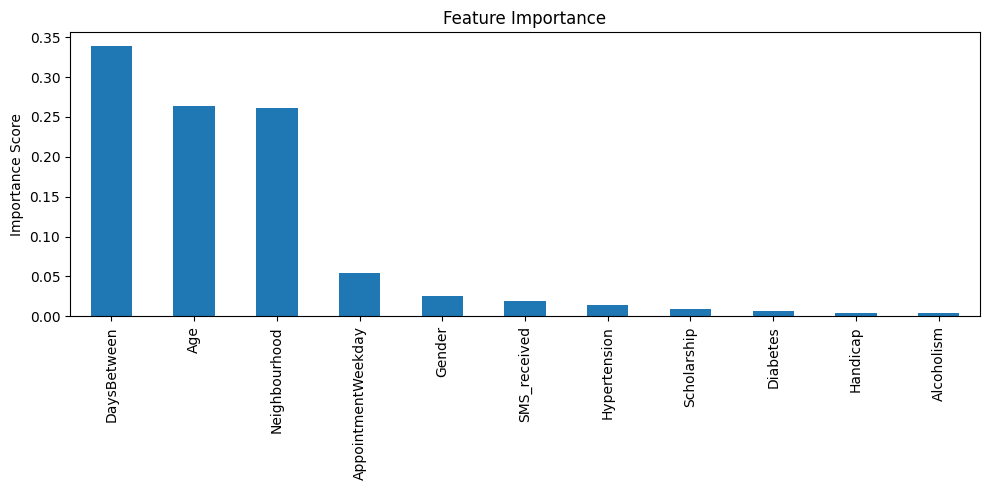

In [68]:
import matplotlib.pyplot as plt

# Get and plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title="Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


In [69]:
import xgboost as xgb

# Check class ratio
class_0, class_1 = y_train.value_counts()
scale = class_0 / class_1

# Train XGBoost with imbalance handling
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("XGBoost Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Model Results:
Accuracy: 0.6096987243282367

Confusion Matrix:
 [[10015  7654]
 [  974  3463]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70     17669
           1       0.31      0.78      0.45      4437

    accuracy                           0.61     22106
   macro avg       0.61      0.67      0.57     22106
weighted avg       0.79      0.61      0.65     22106



In [70]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

results = X_test.copy()
results['Actual'] = y_test
results['Predicted'] = y_pred_xgb
results['Risk_Score'] = y_proba_xgb
results['High_Risk'] = results['Risk_Score'] > 0.8

def suggest_intervention(row):
    if row['Risk_Score'] > 0.9:
        return "Call + Reschedule Option"
    elif row['Risk_Score'] > 0.8:
        return "Phone Call Reminder"
    elif row['Risk_Score'] > 0.6:
        return "SMS Reminder"
    else:
        return "No Action Needed"

results['Suggested_Action'] = results.apply(suggest_intervention, axis=1)
results[['Risk_Score', 'High_Risk', 'Suggested_Action']].head(10)


,Risk_Score,High_Risk,Suggested_Action
84674,0.246802,False,No Action Needed
3635,0.673831,False,SMS Reminder
16605,0.618197,False,SMS Reminder
103942,0.681400,False,SMS Reminder
274,0.113012,False,No Action Needed
48969,0.551856,False,No Action Needed
76571,0.246275,False,No Action Needed
6694,0.105912,False,No Action Needed
54876,0.223848,False,No Action Needed
3235,0.562657,False,No Action Needed


In [71]:
results.to_csv("Appointment_NoShow_Risk_Predictions.csv", index=False)

# Optional: download file from Colab
from google.colab import files
files.download("Appointment_NoShow_Risk_Predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
!pip install gradio --quiet

In [73]:
import gradio as gr

# Define your label encoder if you used one for Gender, Neighbourhood, etc.
gender_map = {'F': 0, 'M': 1}
neighbourhood_encoder = LabelEncoder()
neighbourhood_encoder.fit(df['Neighbourhood'])  # Use original df

# Define intervention logic
def get_intervention(risk):
    if risk > 0.9:
        return "Call + Reschedule Option"
    elif risk > 0.8:
        return "Phone Call Reminder"
    elif risk > 0.6:
        return "SMS Reminder"
    else:
        return "No Action Needed"

# Prediction function
def predict_no_show(gender, age, neighbourhood, scholarship, hypertension,
                    diabetes, alcoholism, handicap, sms_received,
                    days_between, appointment_weekday):

    # Prepare input as dataframe
    input_dict = {
        'Gender': gender_map[gender],
        'Age': age,
        'Neighbourhood': neighbourhood_encoder.transform([neighbourhood])[0],
        'Scholarship': scholarship,
        'Hypertension': hypertension,
        'Diabetes': diabetes,
        'Alcoholism': alcoholism,
        'Handicap': handicap,
        'SMS_received': sms_received,
        'DaysBetween': days_between,
        'AppointmentWeekday': appointment_weekday
    }

    input_df = pd.DataFrame([input_dict])
    prob = xgb_model.predict_proba(input_df)[0][1]
    suggestion = get_intervention(prob)

    return f"📊 Risk Score: {round(prob, 2)}", f"📣 Suggested Action: {suggestion}"


In [74]:
# UI fields
interface = gr.Interface(
    fn=predict_no_show,
    inputs=[
        gr.Radio(['F', 'M'], label="Gender"),
        gr.Slider(0, 100, step=1, label="Age"),
        gr.Dropdown(choices=list(df['Neighbourhood'].unique()), label="Neighbourhood"),
        gr.Radio([0, 1], label="Scholarship"),
        gr.Radio([0, 1], label="Hypertension"),
        gr.Radio([0, 1], label="Diabetes"),
        gr.Radio([0, 1], label="Alcoholism"),
        gr.Slider(0, 4, step=1, label="Handicap"),
        gr.Radio([0, 1], label="SMS_received"),
        gr.Slider(0, 50, step=1, label="DaysBetween (Scheduled - Appointment)"),
        gr.Slider(0, 6, step=1, label="Appointment Weekday (0=Mon, ..., 6=Sun)")
    ],
    outputs=[
        gr.Textbox(label="Risk Score"),
        gr.Textbox(label="Suggested Action")
    ],
    title="Appointment No-Show Predictor",
    description="Enter patient details to predict risk of missing the appointment."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6f2babadf5ebb1a21a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
